In [12]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [14]:
minmaxscaler = MinMaxScaler()

In [15]:
!ls -lah '/content/drive/MyDrive/ST/ dataset'

total 33K
-rw------- 1 root root  548 Mar 18 12:16  classes.json
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 1'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 2'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 3'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 4'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 5'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 6'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 7'
drwx------ 2 root root 4.0K Mar 18 12:16 'Tile 8'


In [16]:
dataset_root_folder = '/content/drive/MyDrive/ST/'

In [17]:
dataset_name = " dataset"

In [18]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks': # 'images
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')): # '.jpg
        #print(image_name)
        a = True

/content/drive/MyDrive/ST/ dataset/Tile 2/masks
/content/drive/MyDrive/ST/ dataset/Tile 4/masks
/content/drive/MyDrive/ST/ dataset/Tile 5/masks
/content/drive/MyDrive/ST/ dataset/Tile 1/masks
/content/drive/MyDrive/ST/ dataset/Tile 3/masks
/content/drive/MyDrive/ST/ dataset/Tile 7/masks
/content/drive/MyDrive/ST/ dataset/Tile 6/masks
/content/drive/MyDrive/ST/ dataset/Tile 8/masks


In [19]:
image_patch_size = 256

In [20]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)

In [21]:
image.shape

(544, 509, 3)

In [22]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [23]:
len(image_patches)

2

In [24]:
print(image_patches.shape)

(2, 1, 1, 256, 256, 3)


In [25]:
minmaxscaler = MinMaxScaler()

In [26]:
image_x = image_patches[0,0,:,:]
#MinMaxScaler
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [27]:
image_y[0].shape

(256, 256, 3)

In [28]:
print(type(image))

<class 'numpy.ndarray'>


In [29]:
type(Image.fromarray(image))

PIL.Image.Image

In [30]:
image.shape

(544, 509, 3)

In [31]:
(image.shape[0]//image_patch_size)*image_patch_size

512

In [32]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [33]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [34]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [35]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [36]:
type(image_dataset[0])

numpy.ndarray

In [37]:
type(np.reshape(image_dataset[0], (image_patch_size, image_patch_size, 3)))

numpy.ndarray

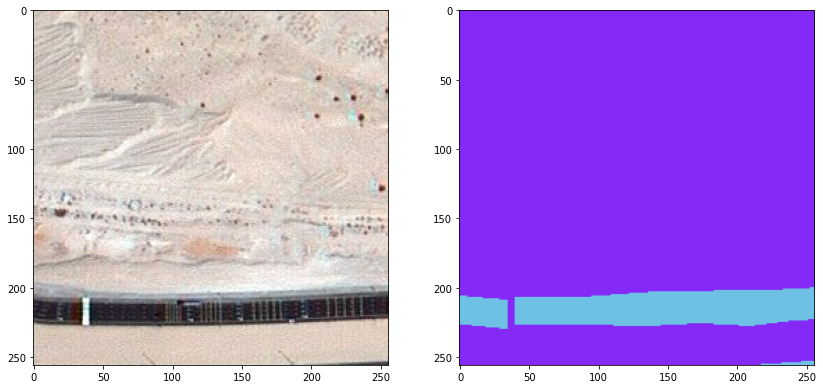

In [38]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [39]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [40]:
mask_dataset.shape[0]

945

In [41]:
label = individual_patched_mask

In [42]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [43]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [44]:
print(len(labels))

945


In [45]:
labels = np.array(labels)

In [46]:
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [47]:
labels = np.expand_dims(labels, axis=3)

In [48]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [49]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [50]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


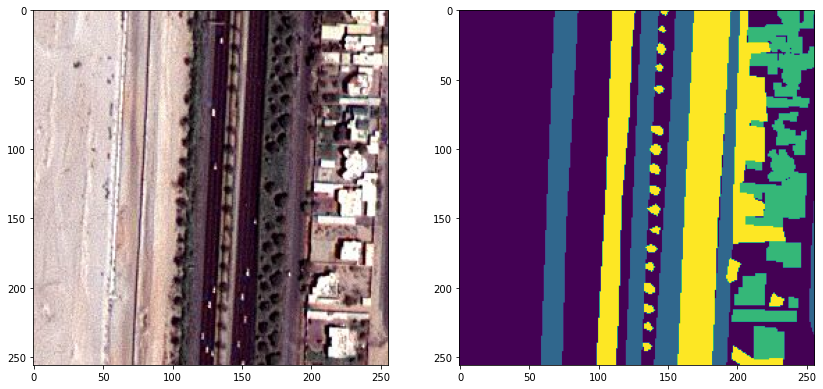

In [51]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [52]:
labels[0][:,:,0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [53]:
total_classes = len(np.unique(labels))

In [54]:
total_classes

6

In [55]:
from tensorflow.keras.utils import to_categorical 

In [56]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [57]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [58]:
master_trianing_dataset = image_dataset

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [62]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [63]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [64]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.8 MB/s eta 0:00:00


In [65]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [66]:

from keras import backend as K

In [67]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [68]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model


In [69]:
metrics = ["accuracy", jaccard_coef]

In [70]:

def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [71]:
model = get_deep_learning_model()

In [72]:

model.compile(optimizer="adam",loss="binary_crossentropy", metrics=metrics)

In [73]:
model_history = model.fit(X_train, y_train,
                          batch_size=5,
                          verbose=2,
                          epochs=10,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/10
161/161 - 40s - loss: 0.3685 - accuracy: 0.4983 - jaccard_coef: 0.3435 - val_loss: 0.2481 - val_accuracy: 0.6624 - val_jaccard_coef: 0.4528 - 40s/epoch - 246ms/step
Epoch 2/10
161/161 - 11s - loss: 0.2229 - accuracy: 0.7158 - jaccard_coef: 0.5193 - val_loss: 0.2278 - val_accuracy: 0.7068 - val_jaccard_coef: 0.5214 - 11s/epoch - 70ms/step
Epoch 3/10
161/161 - 11s - loss: 0.2095 - accuracy: 0.7351 - jaccard_coef: 0.5411 - val_loss: 0.2107 - val_accuracy: 0.7348 - val_jaccard_coef: 0.5307 - 11s/epoch - 68ms/step
Epoch 4/10
161/161 - 11s - loss: 0.2004 - accuracy: 0.7508 - jaccard_coef: 0.5568 - val_loss: 0.2124 - val_accuracy: 0.7341 - val_jaccard_coef: 0.5213 - 11s/epoch - 67ms/step
Epoch 5/10
161/161 - 11s - loss: 0.1928 - accuracy: 0.7615 - jaccard_coef: 0.5680 - val_loss: 0.2128 - val_accuracy: 0.7422 - val_jaccard_coef: 0.5422 - 11s/epoch - 67ms/step
Epoch 6/10
161/161 - 11s - loss: 0.1922 - accuracy: 0.7602 - jaccard_coef: 0.5709 - val_loss: 0.1974 - val_accuracy: 0.7459 

In [75]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]


test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 1s 1s/step


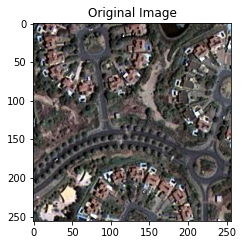

In [76]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)



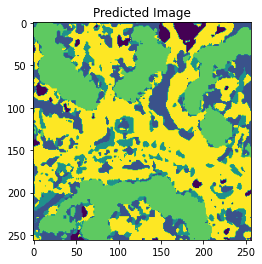

In [77]:
plt.title("Predicted Image")
plt.imshow(predicted_image)